In [1]:
import random
import numpy as np
from utils import *
from ploting import *

## Testing 

In [14]:
def add_noise(world, errRange = 1, mutation_rate = 0):
    _, n_feat = world[:, 1:].shape
    for i, cls_feat in enumerate(world):
        mutation = True if random.random() < mutation_rate else False
        if mutation:
            for j in range(1, n_feat + 1):
                cls_feat[j] = random.random() + errRange * random.uniform(-1, 1)
        else:
            for j in range(1, n_feat + 1):
                cls_feat[j] += errRange * random.uniform(-1, 1)
        world[i] = cls_feat
    return world

In [15]:
from uncertain.util.uncertaintreelearner import UncertainTreeLearner
from uncertain.util.uncertainforestutil import UncertainForestLearner
from uncertain.owtree import ClassificationTreeLearner
from Orange.modelling import RandomForestLearner
from Orange.classification.logistic_regression import LogisticRegressionLearner
from Orange.modelling.constant import ConstantLearner

post_hoc = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=True)
skl_tree = ClassificationTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90)
uncertain_forest = UncertainForestLearner(n_trees=10, max_depth=None, min_samples_split=4)
random_forest = RandomForestLearner(n_trees=10, max_depth=None, min_samples_split=4, max_features = None)
logistic_regression = LogisticRegressionLearner(penalty=None)
majority = ConstantLearner()

In [16]:
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA

def get_world_results(seed, features, errRange, NUMBER_OF_CLASSES, n_sample, rep): 
    results = []
    for err_range in errRange:
        print(f"  World Seed {seed}, errRange {err_range}")
        np.random.seed(seed)
        world = generate_world(seed, features, 
                            feature_bounds = (0, 1), 
                            endT = .2, endA = .3, max_depth = 4,
                            class_number = NUMBER_OF_CLASSES,
                            errRange = err_range, corr = 1)
        _, test_data = convert_np_to_orange(world, features)
        world = add_noise(world, errRange=0.05, mutation_rate=0.1)
        data, _ = convert_np_to_orange(world, features)
        for samples_per_class in n_sample:
            average_CA = np.array([0, 0, 0], dtype="float64")
            majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
            for _ in range(rep):
                res = TestOnTestData(data=sample_data_orange(data, samples_per_class), test_data=test_data, learners=[skl_tree, post_hoc, uncertain_forest])
                average_CA += CA(res)
                # print(sample_data_orange(data, samples_per_class))
                # print(f"    samples_per_class: {samples_per_class}\n    Results:")
            average_CA = average_CA / rep * 100
            results.append([features, seed, err_range, samples_per_class, average_CA[0], average_CA[1], average_CA[2], majority_class])
            # print(f"  Results {samples_per_class}:\n      skl_tree          {round(average_CA[0], 2)}%\n      post_hoc          {round(average_CA[1], 2)}%\n      uncertain_forest  {round(average_CA[2], 2)}%")
    return results
            

In [17]:
from IPython.core.display import HTML

# Custom CSS to change the background color of the progress bar
display(HTML("""
    <style>
        .progress .progress-bar {
            background-color: #f60 !important; /* Change the progress bar background color to black */
        }
    </style>
"""))


### 2 Class

In [18]:
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (0, 1)
n_feat = [2]
n_worlds = 50
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 2
endT=.2
endArea = [.3]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, logistic_regression]
# correlation = [0.9, 0.8, 0.7, 0.6]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2, correlation = 1):
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=correlation)
    _, test_data = convert_np_to_orange(world, features)
    draw_combined_world(world)
    world = add_noise(world, errRange=0.05, mutation_rate=0.1)
    world = data_to_world(world[:, :3],errRange=err_range, corr=correlation)
    
    draw_combined_world(world)
    data, _ = convert_np_to_orange(world, features)
    results = []
    majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)] + [majority_class])                    
    return results

# Main execution block
results = []

# break
feat_PB = tqdm(total=n_worlds*len(errRange))
# for corr in correlation:
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat fuzzy")
        feat_PB.reset()
        with ProcessPoolExecutor() as executor:
            futures = []
            for world_gen_seed in range(n_worlds):
                for err_range in errRange:
                    futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA))

            for future in as_completed(futures):
                results += future.result()
                feat_PB.update()

        df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
        df.to_csv(f"truefuzzydata{0.05}-{0.1}results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases.csv", index=False)
        results = []

# Process results as needed


  0%|          | 0/550 [00:00<?, ?it/s]

TypeError: generate_world() got an unexpected keyword argument 'endT'

### 3 Class

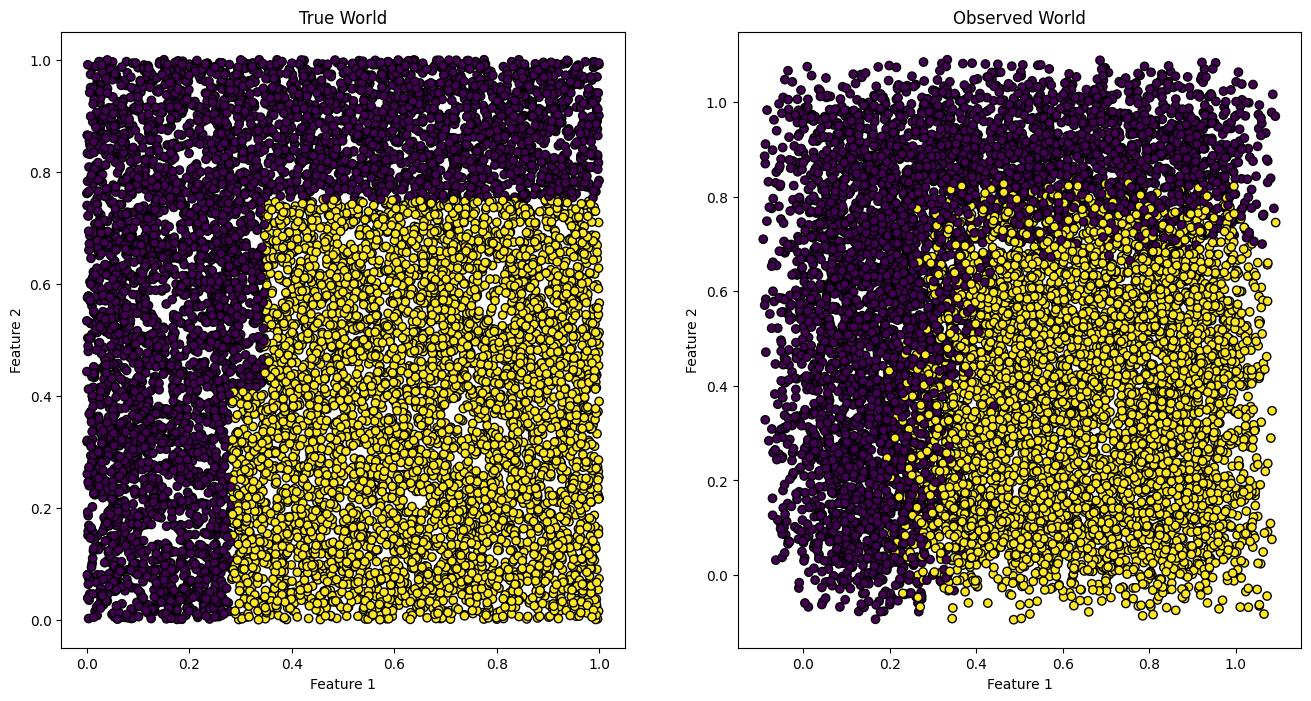

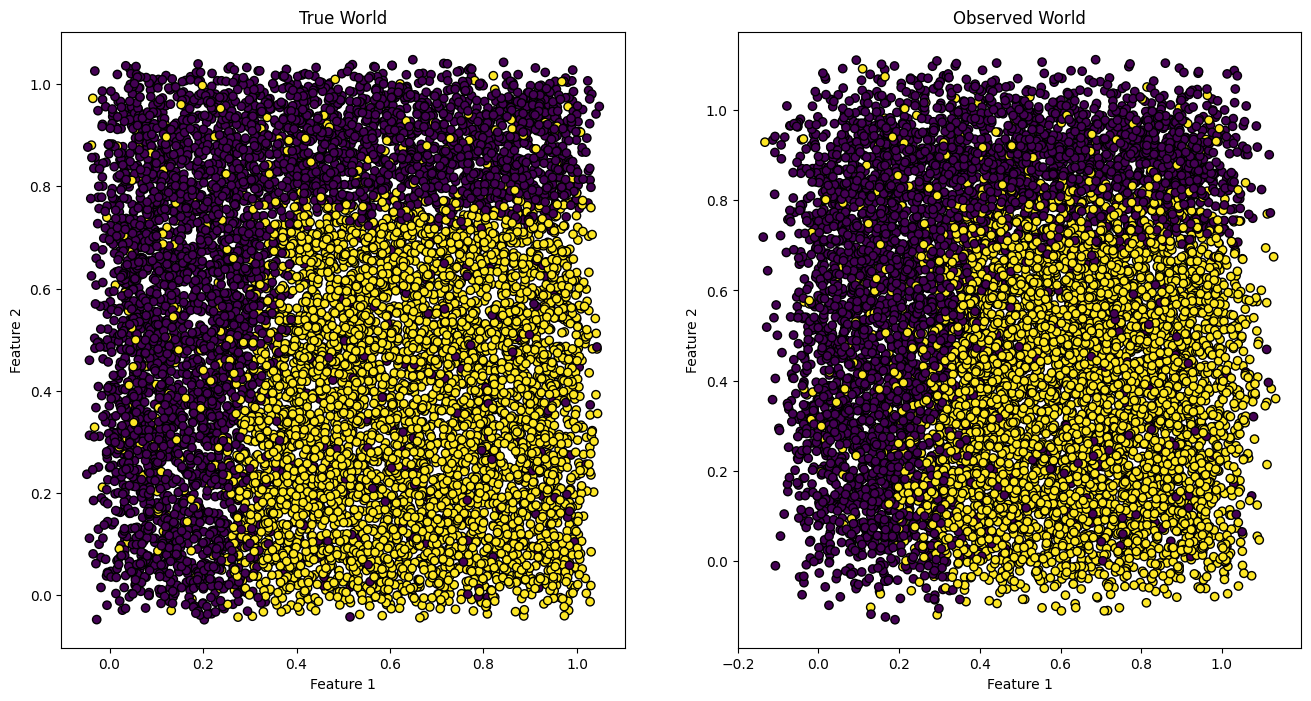

[[2, None, 0.1, 40, 0.9013, 0.8996, 0.9327, 0.8821, 0.8336, 0.5284],
 [2, None, 0.1, 40, 0.9035, 0.875, 0.8915, 0.8876, 0.8332, 0.5284],
 [2, None, 0.1, 40, 0.8489, 0.8791, 0.9344, 0.9388, 0.8301, 0.5284],
 [2, None, 0.1, 40, 0.9571, 0.9691, 0.9553, 0.9343, 0.8193, 0.5284],
 [2, None, 0.1, 40, 0.9256, 0.9404, 0.9496, 0.9691, 0.8368, 0.5284],
 [2, None, 0.1, 40, 0.8163, 0.7989, 0.8257, 0.8498, 0.8259, 0.5284],
 [2, None, 0.1, 40, 0.9435, 0.9119, 0.9453, 0.9552, 0.8377, 0.5284],
 [2, None, 0.1, 40, 0.9017, 0.9107, 0.8936, 0.9164, 0.8341, 0.5284],
 [2, None, 0.1, 40, 0.9099, 0.9168, 0.9152, 0.947, 0.8376, 0.5284],
 [2, None, 0.1, 40, 0.9283, 0.9165, 0.9621, 0.9356, 0.8392, 0.5284],
 [2, None, 0.1, 40, 0.8195, 0.7908, 0.8884, 0.8871, 0.83, 0.5284],
 [2, None, 0.1, 40, 0.9424, 0.9462, 0.9609, 0.9557, 0.8425, 0.5284],
 [2, None, 0.1, 40, 0.9318, 0.9009, 0.8963, 0.9194, 0.8343, 0.5284],
 [2, None, 0.1, 40, 0.8461, 0.8245, 0.8834, 0.8792, 0.8345, 0.5284],
 [2, None, 0.1, 40, 0.9689, 0.9556, 0.

In [28]:
run_experiment(2, None, 0.1, [40], learners)

In [15]:
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (0, 1)
n_feat = [2, 3]
n_worlds = 50
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 3
endT=.2
endArea = [.3, .2, .1]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, logistic_regression]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2):
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=1)
    data, test_data = convert_np_to_orange(world, features)
    results = []
    majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)] + [majority_class])                    
    return results

# Main execution block
results = []

feat_PB = tqdm(total=n_worlds*len(errRange))
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat endArea {endA}")
        feat_PB.reset()
        with ProcessPoolExecutor() as executor:
            futures = []
            for world_gen_seed in range(n_worlds):
                for err_range in errRange:
                    futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA))
            
            for future in as_completed(futures):
                results += future.result()
                feat_PB.update()

        df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
        df.to_csv(f"results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases.csv", index=False)
        results = []

# Process results as needed


  0%|          | 0/550 [00:00<?, ?it/s]

### ostalo

In [25]:
import numpy as np
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm
import multiprocessing as mp
import pandas as pd

feature_bounds = (0, 1)
n_feat = [2]
n_worlds = 2
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 2
endT = .2
endArea = [.1, .2, .3]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, lasso, ridge]

# Function to be executed in parallel
def run_experiment(args):
    features, world_gen_seed, err_range, n_sample, learners, endA = args
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=1)
    data, test_data = convert_np_to_orange(world, features)
    results = []
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)])                    
    return results


results = []

feat_PB = tqdm(total=n_worlds*len(errRange))
    
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat endArea {endA}")
        feat_PB.reset()

        # Prepare a list of arguments for parallel processing
        tasks = [
            (features, world_gen_seed, err_range, n_sample, learners, endA)
            for world_gen_seed in range(n_worlds)
            for err_range in errRange
        ]

        # Use multiprocessing Pool to execute tasks in parallel
        with mp.Pool(mp.cpu_count()) as pool:
            for result in pool.imap_unordered(run_experiment, tasks):
                results.extend(result)
                feat_PB.update()

        # Save results after each feature/endA combination
        # df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "lasso", "ridge"])
        # df.to_csv(f"results{features}feat_{n_worlds}worlds_{endA}endA.csv", index=False)
        # results = []


  0%|          | 0/22 [00:00<?, ?it/s]

## Testing
### Real world

In [1]:
import random
import numpy as np
from utils import *
from ploting import *

In [2]:
def convert_pandas_to_orange(world, number_features):
    
    world["Class"] = world["Class"].astype(int)

    X = np.column_stack([world[f"Observed Value {i+1}"] for i in range(number_features)])
    Y = np.array(world["Class"])
    M = np.column_stack([world[f"Uncertainty {i+1}"] for i in range(number_features)])
    Xtv = np.column_stack([world[f"True Value {i+1}"] for i in range(number_features)])
    Xrv = np.column_stack([world[f"Real Value {i+1}"] for i in range(number_features)])
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))]),
        metas = [ContinuousVariable(f"Uncertainty {i+1}") for i in range(number_features)]
    )
    train_data = Table.from_numpy(domain, X=X, Y=Y, metas=M)
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))])
    )
    test_data_tv = Table.from_numpy(domain, X=Xtv, Y=Y)

    test_data_rv = Table.from_numpy(domain, X=Xrv, Y=Y)
    
    return train_data, test_data_tv, test_data_rv

In [3]:
world = generate_real_world_pandas(world_seed=1, data_seed=1, features=2, 
                        feature_bounds=(-1, 1), 
                        endArea=0.3, max_depth=4,
                        class_number=2,
                        errRange=0.1, corr=1,
                        mutation_rate = 0.1, errRange_real_world = 0.1, corr_real_world = 1)

In [16]:
a,b,c = convert_pandas_to_orange(world, 2)

In [4]:
from uncertain.util.uncertaintreelearner import UncertainTreeLearner
from uncertain.util.uncertainforestutil import UncertainForestLearner
from uncertain.owtree import ClassificationTreeLearner
from Orange.modelling import RandomForestLearner
from Orange.classification.logistic_regression import LogisticRegressionLearner
from Orange.modelling.constant import ConstantLearner

post_hoc = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=True)
skl_tree = ClassificationTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90)
uncertain_forest = UncertainForestLearner(n_trees=10, max_depth=None, min_samples_split=4)
random_forest = RandomForestLearner(n_trees=10, max_depth=None, min_samples_split=4, max_features = None)
logistic_regression = LogisticRegressionLearner(penalty=None)
majority = ConstantLearner()

In [ ]:
from utils import *
from ploting import *
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (0, 1)
n_feat = [2]
n_worlds = 2
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 2
endT=.2
endArea = [.3]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, logistic_regression]
# correlation = [0.9, 0.8, 0.7, 0.6]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2, correlation = 1):
    np.random.seed(world_gen_seed)
    world = generate_real_world_pandas(world_seed=world_gen_seed, data_seed=1, features=2, 
                        feature_bounds=feature_bounds, 
                        endArea=endA, max_depth=max_depth,
                        class_number=NUMBER_OF_CLASSES,
                        errRange=err_range, corr=correlation,
                        mutation_rate = 0.05, errRange_real_world = 0.1, corr_real_world = 0.8)
    
    train_data, test_data_tv, test_data_rv = convert_pandas_to_orange(world, features)
    
    results_tv = []
    results_rv = []
    majority_class = CA(TestOnTestData(test_data_tv, test_data=test_data_tv, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            data = sample_data_orange(train_data, samples_per_class)
            res_tv = TestOnTestData(data=data, 
                                test_data=test_data_tv, 
                                learners=learners)
            res_rv = TestOnTestData(data=data, 
                                test_data=test_data_rv, 
                                learners=learners)
            results_tv.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res_tv)] + [majority_class])                    
            results_rv.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res_rv)] + [majority_class])                    
    return results_tv, results_rv

# Main execution block
results_tv = []
results_rv = []

# break
feat_PB = tqdm(total=n_worlds*len(errRange))
# for corr in correlation:
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat fuzzy")
        feat_PB.reset()
        with ProcessPoolExecutor() as executor:
            futures = []
            for world_gen_seed in range(n_worlds):
                for err_range in errRange:
                    futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA))

            for future in as_completed(futures):
                tv, rv = future.result()
                # results_tv += future.result()
                results_tv += tv
                results_rv += rv
                feat_PB.update()

        df = pd.DataFrame(results_tv, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
        df.to_csv(f"truefuzzydata{0.05}-{0.1}_results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases.csv", index=False)
        df = pd.DataFrame(results_rv, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
        df.to_csv(f"fuzzyfuzzydata{0.05}-{0.1}_results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases.csv", index=False)
        results_tv = [] 
        results_rv = []

# Process results as needed


  0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor

In [11]:
run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA)

([[2, 1, 1.0, 5, 0.4802, 0.4558, 0.4518, 0.3631, 0.5346, 0.694],
  [2, 1, 1.0, 5, 0.5236, 0.694, 0.5886, 0.4408, 0.6455, 0.694],
  [2, 1, 1.0, 5, 0.5296, 0.5314, 0.5302, 0.5436, 0.5029, 0.694],
  [2, 1, 1.0, 5, 0.5821, 0.4715, 0.5624, 0.519, 0.6193, 0.694],
  [2, 1, 1.0, 5, 0.6449, 0.5487, 0.5587, 0.6417, 0.5279, 0.694],
  [2, 1, 1.0, 5, 0.306, 0.3469, 0.306, 0.407, 0.3184, 0.694],
  [2, 1, 1.0, 5, 0.6996, 0.4516, 0.419, 0.701, 0.5669, 0.694],
  [2, 1, 1.0, 5, 0.3549, 0.3332, 0.3146, 0.3341, 0.4018, 0.694],
  [2, 1, 1.0, 5, 0.3436, 0.4414, 0.694, 0.5981, 0.6806, 0.694],
  [2, 1, 1.0, 5, 0.5319, 0.4961, 0.3229, 0.5898, 0.6796, 0.694],
  [2, 1, 1.0, 5, 0.4597, 0.7446, 0.64, 0.4338, 0.4268, 0.694],
  [2, 1, 1.0, 5, 0.306, 0.306, 0.306, 0.3279, 0.367, 0.694],
  [2, 1, 1.0, 5, 0.5058, 0.5238, 0.7018, 0.6476, 0.7018, 0.694],
  [2, 1, 1.0, 5, 0.4641, 0.694, 0.5581, 0.5606, 0.6303, 0.694],
  [2, 1, 1.0, 5, 0.4503, 0.5628, 0.5628, 0.3913, 0.5019, 0.694],
  [2, 1, 1.0, 5, 0.3949, 0.418, 0.418, 0